# Explore atlases

## Load rs-fMRI dataset

### Use Nilearn to fetch developmental fMRI data

In [1]:
from nilearn import datasets

# Add dataset to Original_Data and include all confounds
data = datasets.fetch_development_fmri(data_dir='../Original_Data', reduce_confounds=False)

### Create DataLad dataset for raw developmental fMRI data

In [9]:
from datalad import api

api.create(path='../Original_Data', force=True)

[INFO] Creating a new annex repo at /Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data 


<Dataset path=/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data>

### Save state of DataLad dataset

In [10]:
api.save(path='../Original_Data', message='Fetch development_fMRI dataset using Nilearn and create DataLad dataset')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/development_fmri/development_fmri/participants.tsv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/development_fmri/development_fmri/sub-pixar001_task-pixar_desc-confounds_regressors.tsv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Dat

### Create DataLad dataset for data generated by analysis

In [113]:
api.create(path='../Analysis_Data', force=True)

[INFO] Creating a new annex repo at /Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data 


<Dataset path=/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data>

### Save state of DataLad dataset

In [114]:
api.save(path='../Analysis_Data', message='Create DataLad dataset for data generated by analysis')

[{'action': 'save',
  'type': 'dataset',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project',
  'status': 'notneeded'}]

## Load phenotypic information

In [2]:
import pandas

pheno = pandas.DataFrame(data.phenotypic)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


### Assess class balance

In [64]:
# Assign Age to variable
y_age = pheno['Age']

# Assign AgeGroup to variable and check counts of each age group
age_class = pheno['AgeGroup']
age_class.value_counts()

5yo       34
8-12yo    34
Adult     33
7yo       23
3yo       17
4yo       14
Name: AgeGroup, dtype: int64

## Functional atlas

### Load BASC multiscale atlas

In [4]:
# Load atlas with 64 ROIs
parcellations_basc = datasets.fetch_atlas_basc_multiscale_2015(data_dir='../Original_Data')
atlas_filename_basc = parcellations_basc.scale064

In [30]:
# Save state of DataLad dataset
api.save(path='../Original_Data/basc_multiscale_2015', message='Download BASC multiscale atlas')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/README.md',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale007.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale012.nii.gz',
  'type': 'file',
  'refds': '/Users/Stor

### Plot atlas

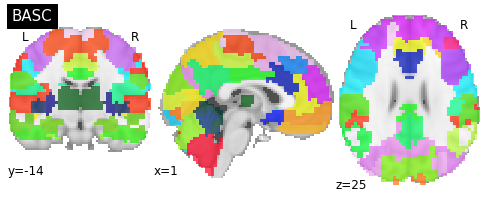

In [5]:
from nilearn import plotting

# Plot atlas
display = plotting.plot_roi(atlas_filename_basc, draw_cross=False, title="BASC")
# Save atlas plot
display.savefig('../Analysis_Data/BASC.png')

### Feature extraction for computing correlation matrices

In [8]:
# Define function for initializing label masker
def mask_init_labels(atlas):
    masker = NiftiLabelsMasker(labels_img=atlas, standardize=True, 
                           memory='nilearn_cache', verbose=0)
    return masker

In [9]:
# Define function for initializaing connectivity measure
def corr_measure(diag):
    correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=diag)               # Keep/Discard diagonal
    return correlation_measure

In [60]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_basc)
correlation_measure = corr_measure(diag=False)

In [11]:
# Define function to extract features for visualization of individual correlation matrices
def feat_extract_corr(masker, correlation_measure):
    all_features = [] # Empty list for containing all features (correlations)
    
    # Extract signal based on labels defined by atlas
    for i,sub in enumerate(data.func):
        # Extract timeseries from each ROI in atlas
        time_series = masker.fit_transform(sub, confounds=data.confounds[i])
        # Create region x region correlation matrix
        correlation_matrix_ind = correlation_measure.fit_transform([time_series])[0]
        # Add correlation matrix to feature container
        all_features.append(correlation_matrix_ind)
        # Track progress
        #print('finished %s of %s'%(i+1,len(data.func)))
        
        # Convert feature list to numpy array
        X_features = np.array(all_features)
        # Convert vectorized matrix to symmetric matrix
        ind_matrices = vec_to_sym_matrix(X_features)
        
    return time_series, ind_matrices

In [13]:
from nilearn.connectome import vec_to_sym_matrix
import numpy as np

# Extract features for generatin of individual correlation matrices
time_series_BASC_all, ind_matrices_BASC_all = feat_extract_corr(masker, correlation_measure)

### Plot correlation matrix for subject

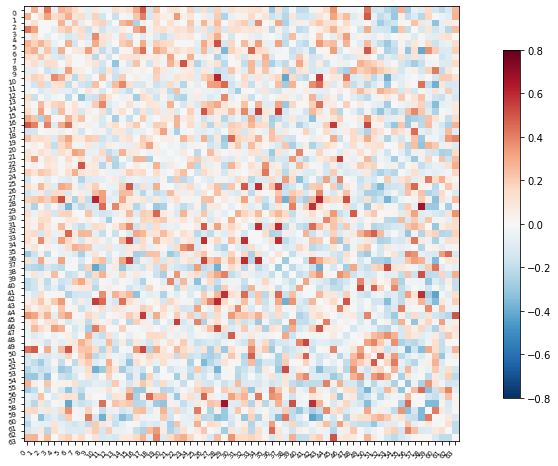

In [32]:
# Identify subject index
subject = 40

# Mask out major diagonal
np.fill_diagonal(ind_matrices_BASC_all[subject], 0)
# Plot correlation matrix
display = plotting.plot_matrix(ind_matrices_BASC_all[subject], figure=(10, 8),   
                     labels=range(time_series_BASC_all.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)
# Save correlation matrix
display.figure.savefig('../Analysis_Data/BASC_corr.png')

### Plot connectome

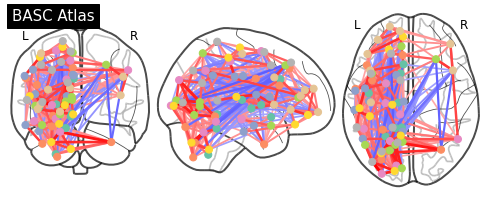

In [30]:
# Identify center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename_basc)

# Plot connectome with 80% edge strength
display = plotting.plot_connectome(ind_matrices_BASC_all[subject], coordinates,
                         edge_threshold="80%",
                         title='BASC Atlas')
# Save connectome plot
display.savefig('../Analysis_Data/BASC_connectome.png')

### Feature extraction for model

In [26]:
# Define function to extract features for support vector regression model
def feat_extract_model(masker, correlation_measure):
    all_features = [] # Empty list for containing all features (correlations)
    
    # Extract signal based on labels defined by atlas
    for i,sub in enumerate(data.func):
        # Extract timeseries from each ROI in atlas
        time_series = masker.fit_transform(sub, confounds=data.confounds[i])
        # Create region x region correlation matrix
        correlation_matrix = correlation_measure.fit_transform([time_series])[0]
        # Add correlation matrix to feature container
        all_features.append(correlation_matrix)
        # Track progress
        #print('finished %s of %s'%(i+1,len(data.func)))
        
        # Convert feature list to numpy array
        X_features = np.array(all_features)
        
    return X_features

In [61]:
# Perform feature extraction
correlation_measure = corr_measure(diag=True)

X_features_BASC_all = feat_extract_model(masker, correlation_measure)

### Plot feature matrix

Text(0, 0.5, 'Subjects')

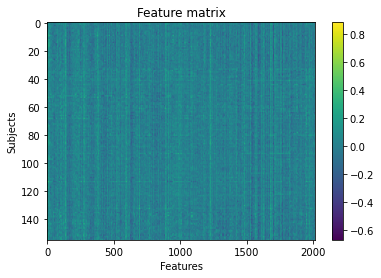

In [29]:
import matplotlib.pyplot as plt

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('Feature matrix')
plt.xlabel('Features')
plt.ylabel('Subjects')

### Define model for age prediction

In [30]:
from sklearn.svm import SVR
l_svr = SVR(kernel='linear')

In [69]:
len(X_features_BASC_all)
len(y_age)

155

In [73]:
! datalad run python train_model.py {X_features_BASC_all} {y_age} {age_class} --flag1

[INFO   ] == Command start (output follows) ===== 
[[
[INFO   ] == Command exit (modification check follows) ===== 
add(ok): Command_Files/rs-fMRI_age_prediction.ipynb (file)
save(ok): . (dataset)
action summary:
  add (ok: 1)
  save (notneeded: 1, ok: 1)
/bin/sh: line 1: 0.2788601: command not found
/bin/sh: line 2: [: missing `]'
/bin/sh: line 3: -0.22558261]: command not found
/bin/sh: line 4: [: missing `]'
/bin/sh: line 5: 0.0812546: command not found
/bin/sh: line 6: ...: command not found
/bin/sh: line 7: [: missing `]'
/bin/sh: line 8: -0.00733841]: command not found
/bin/sh: line 9: [: missing `]'
/bin/sh: line 10: -0.08431097]: command not found
/bin/sh: line 11: [: missing `]'
/bin/sh: line 12: 0.13195395]]: command not found
/bin/sh: line 13: 1: command not found
/bin/sh: line 14: 2: command not found
/bin/sh: line 15: 3: command not found
/bin/sh: line 16: 4: command not found
/bin/sh: line 17: ...: command not found
/bin/sh: line 18: 150: command not found
/bin/sh: line 1

In [74]:
y_pred_all

NameError: name 'y_pred_all' is not defined

### Generate training/validation splits

In [37]:
# Define function for generating training/validation splits
# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

def train_val(X_features, y_age, age_class):
    n_splits = 10

    X_train_container = []
    X_val_container = []
    y_train_container = []
    y_val_container = []

    for i in range(n_splits):
        X_train, X_val, y_train, y_val = train_test_split(
                                                        X_features, # x
                                                        y_age, # y
                                                        test_size = 0.25, # 75%/25% split  
                                                        shuffle = True, # Shuffle dataset
                                                                        # before splitting
                                                        stratify = age_class,  # keep
                                                                               # distribution
                                                                               # of ageclass
                                                                               # consistent
                                                                               # betw. train
                                                                               # & test sets.
                                                                           )

        X_train_container.append(X_train)
        X_val_container.append(X_val)
        y_train_container.append(y_train)
        y_val_container.append(y_val)
    
    # Print size of our training and test groups
    print('training:', len(X_train),
         'testing:', len(X_val))
    
    return X_train_container, X_val_container, y_train_container, y_val_container

In [38]:
from sklearn.model_selection import train_test_split

X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_BASC_all, y_age, age_class)

training: 116 testing: 39


### Fit model to training data using 10-fold CV

In [39]:
# Define function for fitting model to training data using 10-fold cross-validation

def model_fit(X_train_container, y_train_container):
    # Build a tiny pipeline that does feature selection (top 20% of features), 
    # and then prediction with our linear svr model.
    model = Pipeline([
        ('feature_selection',SelectPercentile(f_regression,percentile=20)),
        ('prediction', l_svr)
                     ])
    y_pred_all = []
    y_index_all = []

    for j in range(len(X_train_container)):

        y_pred = [] # Container to catch predictions from each fold
        y_index = [] # Index for each prediction

        # First we create 10 splits of the data
        skf = KFold(n_splits=10, shuffle=True, random_state=123)

        # For each split, assemble the train and test samples 
        for tr_ind, te_ind in skf.split(X_train_container[j]):
            X_tr = X_train_container[j][tr_ind]
            y_tr = y_train_container[j].values[tr_ind]
            X_te = X_train_container[j][te_ind]
            y_index += list(te_ind) # Store the index of samples to predict
    
            # Run pipeline 
            model.fit(X_tr, y_tr) # Fit data to the model using mini pipeline
            predictions = model.predict(X_te).tolist() # Get predictions for this fold
            y_pred += predictions # Add to list of predictions
        
        y_index_all.append(y_index)
        y_pred_all.append(y_pred)
        
    return y_index_all, y_pred_all

In [41]:
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

### Evaluate model using accuracy and mean absolute error

Mean R2: 0.6521592372901218
Mean MAE: 3.260674556356065


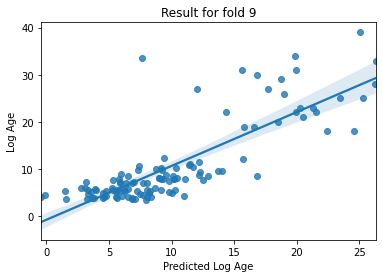

In [43]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [286]:
# Decide whether or not this needs to be saved
import scipy.io as sio

sio.savemat('atlas1.mat', {'y_pred_all': y_pred_all[k], 'y_train_container': np.array(y_train_container)[k][y_index_all[k]]})

## Structural atlas

### Load AAL atlas

In [34]:
# Load atlas
parcellations_aal = datasets.fetch_atlas_aal(data_dir='../Original_Data')
atlas_filename_aal = parcellations_aal.maps

In [32]:
# Save state of DataLad dataset
api.save(path='../Original_Data/aal_SPM12', message='Download AAL atlas')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/aal_SPM12/aal/ROI_MNI_V4.nii',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/aal_SPM12/aal/ROI_MNI_V4.txt',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/aal_SPM12/aal/ROI_MNI_V4.xml',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data

### Plot atlas

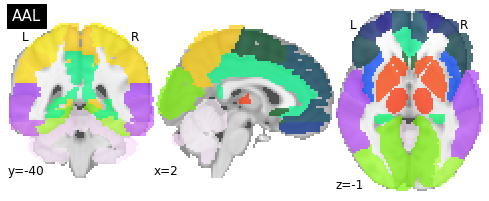

In [35]:
# Plot atlas
display = plotting.plot_roi(atlas_filename_aal, draw_cross=False, title="AAL")
# Save atlas plot
display.savefig('../Analysis_Data/AAL.png')

### Feature extraction for computing correlation matrices

In [36]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=False)

# Extract features for generatin of individual correlation matrices
time_series_AAL_all, ind_matrices_AAL_all = feat_extract_corr(masker, correlation_measure)

### Plot correlation matrix

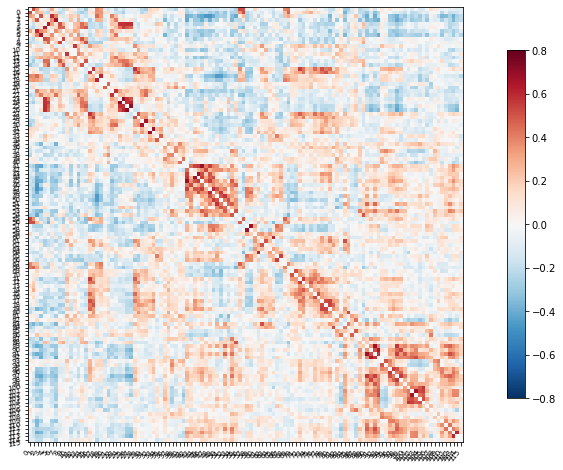

In [38]:
# Identify subject index
subject = 40

# Mask out major diagonal
np.fill_diagonal(ind_matrices_AAL_all[subject], 0)
# Plot correlation matrix
display = plotting.plot_matrix(ind_matrices_AAL_all[subject], figure=(10, 8),   
                     labels=range(time_series_AAL_all.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)
# Save correlation matrix
display.figure.savefig('../Analysis_Data/AAL_corr.png')

### Plot connectome

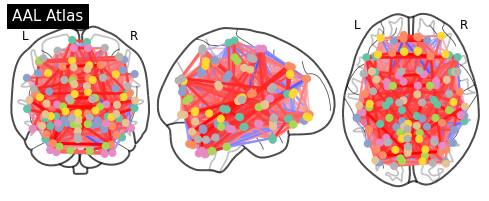

In [40]:
# Identify center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename_aal)

# Plot connectome with 80% edge strength
display = plotting.plot_connectome(ind_matrices_AAL_all[subject], coordinates,
                         edge_threshold="80%",
                         title='AAL Atlas')
# Save connectome plot
display.savefig('../Analysis_Data/AAL_connectome.png')

### Perform SVR analysis

training: 116 testing: 39
Mean R2: 0.6573793943284957
Mean MAE: 3.5505747793526643


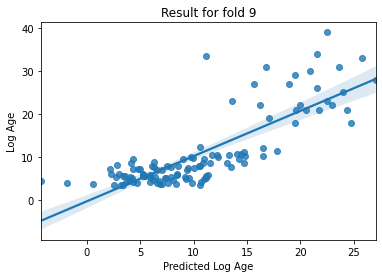

In [49]:
# Initialize connectivity measure
correlation_measure = corr_measure(diag=True)

# Extract features for model
X_features_AAL_all = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_AAL_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [290]:
import scipy.io as sio

sio.savemat('atlas2.mat', {'y_pred_all1': y_pred_all[k], 'y_train_container1': np.array(y_train_container)[k][y_index_all[k]]})


## Clustering method atlas

### Load CRAD atlas

In [41]:
# Load atlas
parcellations_crad = datasets.fetch_atlas_craddock_2012(data_dir='../Original_Data')
atlas_filename_crad = parcellations_crad.random

In [46]:
# Save state of DataLad dataset
api.save(path='../Original_Data/craddock_2012', message='Download Craddock atlas')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/craddock_2012/random_all.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/craddock_2012/scorr05_2level_all.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/craddock_2012/scorr05_mean_all.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs202

### Plot atlas

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


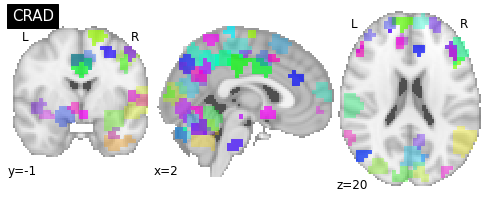

In [42]:
# Plot atlas
display = plotting.plot_prob_atlas(atlas_filename_crad, view_type='continuous', draw_cross=False, title="CRAD")
# Save atlas plot
display.savefig('../Analysis_Data/CRAD.png')

### Feature extraction for computing correlation matrices

In [44]:
# Define function for initializing map masker (used for probabilistic atlases)
def mask_init_maps(atlas):
    masker = NiftiMapsMasker(maps_img=atlas, standardize=True, 
                           memory='nilearn_cache', verbose=0)
    return masker

In [45]:
from nilearn.input_data import NiftiMapsMasker

# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=False)

# Extract features for generatin of individual correlation matrices
time_series_CRAD_all, ind_matrices_CRAD_all = feat_extract_corr(masker, correlation_measure)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


### Plot correlation matrix

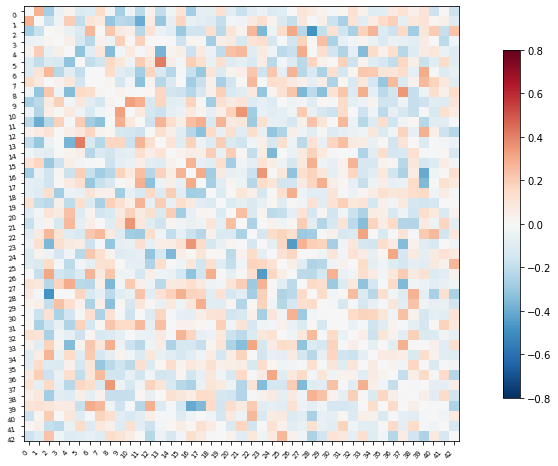

In [46]:
# Identify subject index
subject = 40

# Mask out major diagonal
np.fill_diagonal(ind_matrices_CRAD_all[subject], 0)
# Plot correlation matrix
display = plotting.plot_matrix(ind_matrices_CRAD_all[subject], figure=(10, 8),   
                     labels=range(time_series_CRAD_all.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)
# Save correlation matrix
display.figure.savefig('../Analysis_Data/CRAD_corr.png')

### Plot connectome

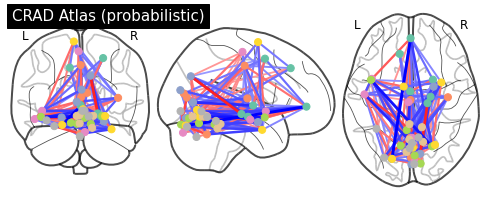

In [47]:
# Identify center coordinates for atlas labels
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=atlas_filename_crad)

# Plot connectome with 80% edge strength
display = plotting.plot_connectome(ind_matrices_CRAD_all[subject], coordinates,
                         edge_threshold="80%",
                         title='CRAD Atlas (probabilistic)')
# Save connectome plot
display.savefig('../Analysis_Data/CRAD_connectome.png')

### Perform SVR analysis

training: 116 testing: 39
Mean R2: 0.5097219341601865
Mean MAE: 3.6968620192866917


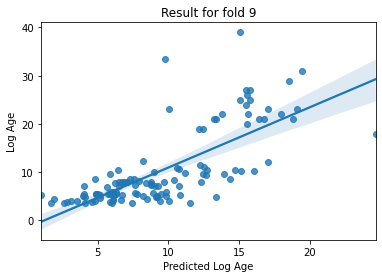

In [58]:
# Initialize connectivity measure
correlation_measure = corr_measure(diag=True)

# Extract features for model
X_features_CRAD_all = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_CRAD_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [317]:
sio.savemat('atlas3.mat', {'y_pred_all2': y_pred_all[k], 'y_train_container2': np.array(y_train_container)[k][y_index_all[k]]})


## Linear decomposition methods atlas

### Load MSDL atlas

In [49]:
# Load atlas
parcellations_msdl = datasets.fetch_atlas_msdl(data_dir='../Original_Data')
atlas_filename_msdl = parcellations_msdl.maps

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [60]:
# Save state of DataLad dataset
api.save(path='../Original_Data/msdl_atlas', message='Download MSDL atlas')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/msdl_atlas/MSDL_rois/README.txt',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/msdl_atlas/MSDL_rois/msdl_rois_labels.csv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'save',
  'type': 'dataset',
  'path': '/Users/Storme/brainhack/Project/

### Plot atlas

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


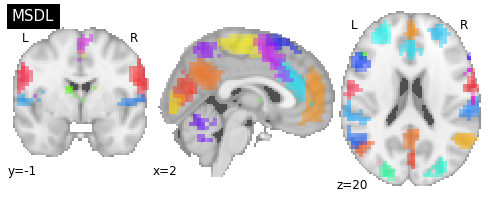

In [50]:
# Plot atlas
display = plotting.plot_prob_atlas(atlas_filename_msdl, view_type='continuous', draw_cross=False, title="MSDL")
# Save atlas plot
display.savefig('../Analysis_Data/MSDL.png')

### Feature extraction for computing correlation matrices

In [51]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=False)

# Extract features for generatin of individual correlation matrices
time_series_MSDL_all, ind_matrices_MSDL_all = feat_extract_corr(masker, correlation_measure)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


### Plot correlation matrix

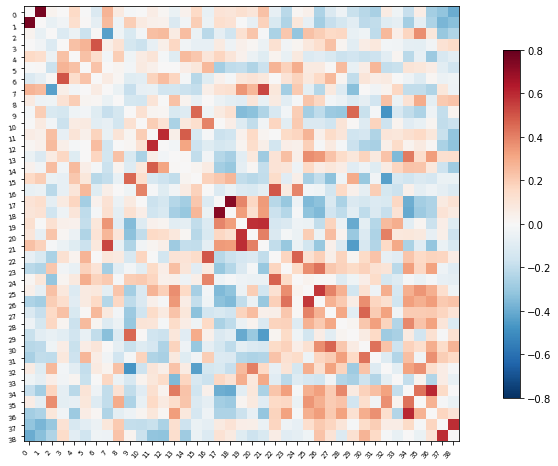

In [52]:
# Mask out major diagonal
np.fill_diagonal(ind_matrices_MSDL_all[40], 0)
# Plot correlation matrix
display = plotting.plot_matrix(ind_matrices_MSDL_all[40], figure=(10, 8),   
                     labels=range(time_series_MSDL_all.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)
# Save correlation matrix
display.figure.savefig('../Analysis_Data/MSDL_corr.png')

### Plot connectome

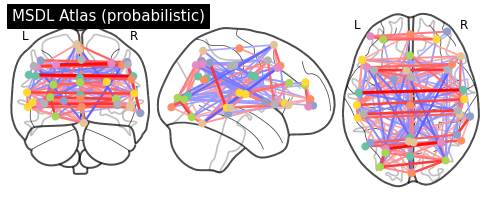

In [53]:
# Identify center coordinates for atlas labels
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=atlas_filename_msdl)

# Plot connectome with 80% edge strength
display = plotting.plot_connectome(ind_matrices_MSDL_all[subject], coordinates,
                         edge_threshold="80%",
                         title='MSDL Atlas (probabilistic)')
# Save connectome plot
display.savefig('../Analysis_Data/MSDL_connectome.png')

### Perform SVR analysis

training: 116 testing: 39
Mean R2: 0.45451864019362864
Mean MAE: 4.206199145941482


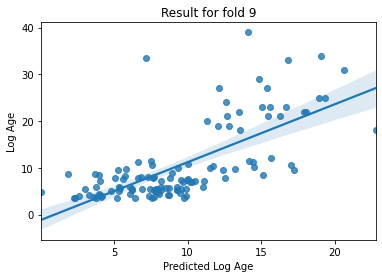

In [64]:
# Initialize connectivity measure
correlation_measure = corr_measure(diag=True)

# Extract features for model
X_features_MSDL_all = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_MSDL_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [321]:
sio.savemat('atlas4.mat', {'y_pred_all3': y_pred_all[k], 'y_train_container3': np.array(y_train_container)[k][y_index_all[k]]})


# Explore confounds

## Functional atlas-CSF

### Load all confounds as dataframes

In [85]:
for filename in data.confounds:
    df = pd.read_csv(filename, sep='\t')
    all_conf.append(df)

In [97]:
# Define function to extract features for support vector regression model using confound option
def feat_extract_model_confounds(masker, correlation_measure, confounds, conf_type):
    all_features = [] # Empty list for containing all features (correlations)
    
    if conf_type == 'CSF':
        drop_list = ['white_matter','global_signal']
    elif conf_type == 'WM':
        drop_list = ['csf','global_signal']
    elif conf_type == 'global':
        drop_list = ['csf','white_matter']
    elif conf_type == 'motion':
        drop_list = ['framewise_displacement']
        
    # Extract signal based on labels defined by atlas
    for i,sub in enumerate(data.func):
        # Extract timeseries from each ROI in atlas
        time_series = masker.fit_transform(sub, confounds=confounds[i].drop(drop_list, axis=1).to_numpy())
        # Create region x region correlation matrix
        correlation_matrix = correlation_measure.fit_transform([time_series])[0]
        # Add correlation matrix to feature container
        all_features.append(correlation_matrix)
        # Track progress
        #print('finished %s of %s'%(i+1,len(data.func)))
        
        # Convert feature list to numpy array
        X_features = np.array(all_features)
        
    return X_features

### Perform SVR analysis

training: 116 testing: 39
Mean R2: 0.668832237769287
Mean MAE: 3.115134188240005


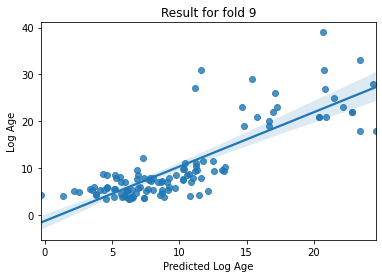

In [98]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_basc)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_BASC_CSF = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_BASC_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Functional atlas-white matter

### Perform SVR analysis

training: 116 testing: 39
Mean R2: 0.6496332559021152
Mean MAE: 3.360193495312326


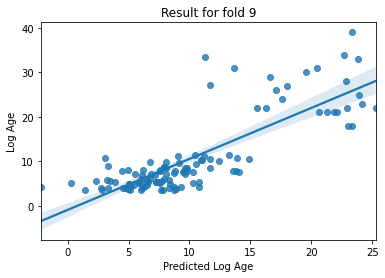

In [99]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_basc)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_BASC_WM = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_BASC_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Functional atlas-global signal

### Perform SVR Analysis

training: 116 testing: 39
Mean R2: 0.6289496513657941
Mean MAE: 3.0700256032309423


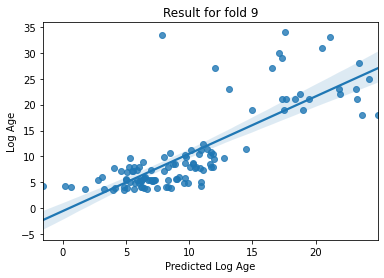

In [100]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_basc)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_BASC_global = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_BASC_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Functional atlas-motion

### Perform SVR analysis

training: 116 testing: 39
Mean R2: 0.6541838887596275
Mean MAE: 3.2647322388358715


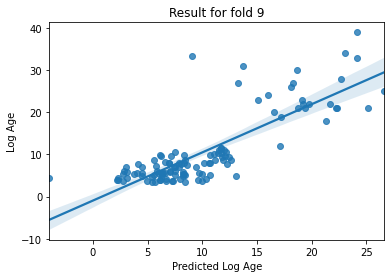

In [101]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_basc)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_BASC_motion = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_BASC_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Structural atlas-CSF

### Perform SVR Analysis

training: 116 testing: 39
Mean R2: 0.6482795738565938
Mean MAE: 3.1811846373648636


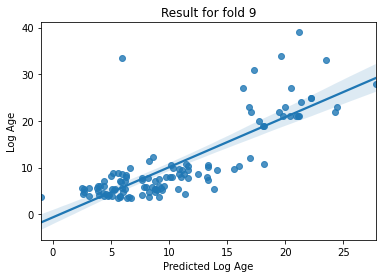

In [102]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_AAL_CSF = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_AAL_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Structural atlas-white matter

### Perform SVR Analysis

training: 116 testing: 39
Mean R2: 0.7135076182522164
Mean MAE: 3.098076071233337


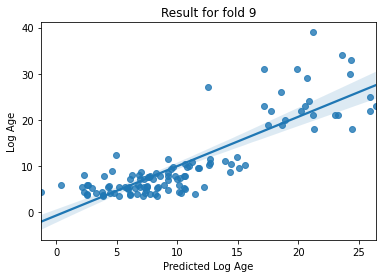

In [103]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_AAL_WM = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_AAL_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Structural atlas-global signal

### Perform SVR Analysis

training: 116 testing: 39
Mean R2: 0.7117798628430465
Mean MAE: 2.9901483067636048


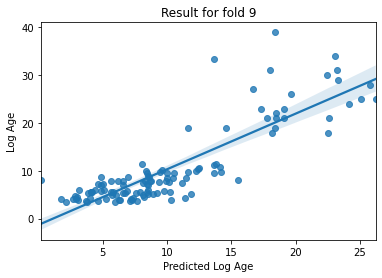

In [104]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_AAL_global = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_AAL_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Structural atlas-motion

### Perform SVR Analysis

training: 116 testing: 39
Mean R2: 0.6360701695275878
Mean MAE: 3.3056457519255362


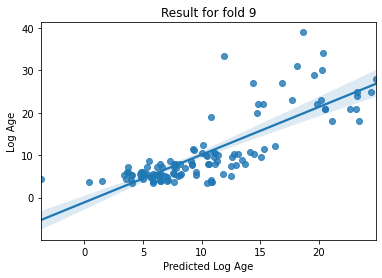

In [105]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_AAL_motion = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_AAL_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Clustering method atlas-CSF

### Perform SVR Analysis

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
Mean R2: 0.5021757961722565
Mean MAE: 3.866203989186554


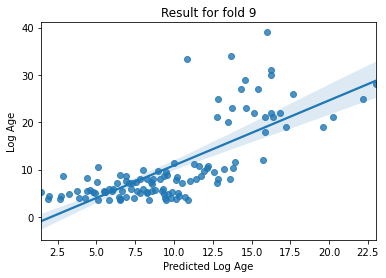

In [106]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_CRAD_CSF = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_CRAD_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Clustering method atlas-white matter

### Perform SVR Analysis

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
Mean R2: 0.4102213585564387
Mean MAE: 4.434265559900127


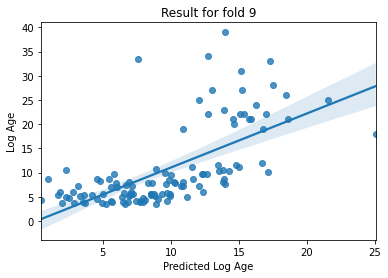

In [108]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_CRAD_WM = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_CRAD_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Clustering method atlas-global signal

### Perform SVR Analysis

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
Mean R2: 0.44557944013116046
Mean MAE: 4.236143152561383


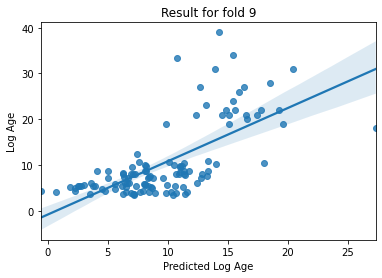

In [109]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_CRAD_global = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_CRAD_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Clustering method atlas-motion

### Perform SVR Analysis

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
Mean R2: 0.4388908454009842
Mean MAE: 4.19673745040676


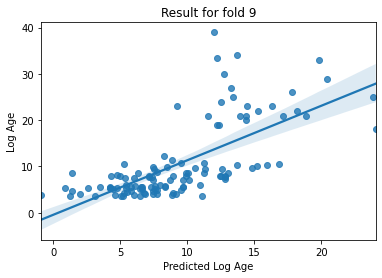

In [110]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_CRAD_motion = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_CRAD_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [262]:
import plotly.express as px
import pandas as pd
#y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]]
df = pd.DataFrame(dict(R1=y_pred_all[k], NOS=np.array(y_train_container)[k][y_index_all[k]]))
px.scatter(df, x="R1", y="NOS" ,labels={'x':'R1', 'y':'NOS'}, trendline="ols").show()


ModuleNotFoundError: No module named 'statsmodels'

## Linear decomposition methods atlas-CSF

### Perform SVR Analysis

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
Mean R2: 0.45807629965384355
Mean MAE: 4.392775331852888


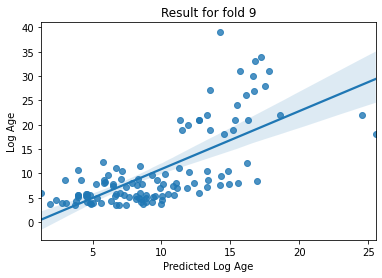

In [111]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_MSDL_CSF = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_MSDL_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Linear decomposition methods atlas-white matter

### Perform SVR Analysis

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
Mean R2: 0.49617053818959345
Mean MAE: 3.822573833579896


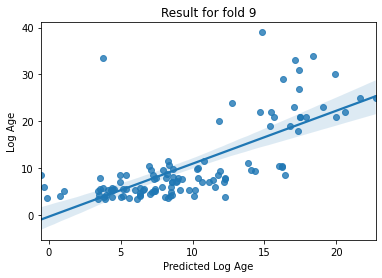

In [112]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_MSDL_WM = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_MSDL_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Linear decomposition methods atlas-global signal

### Perform SVR Analysis

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
Mean R2: 0.5241144431360621
Mean MAE: 3.7226950495679096


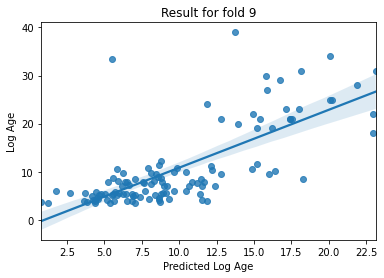

In [113]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_MSDL_global = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_MSDL_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Linear decomposition methods atlas-motion

### Perform SVR Analysis

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
Mean R2: 0.5498282474163926
Mean MAE: 3.6293883462874197


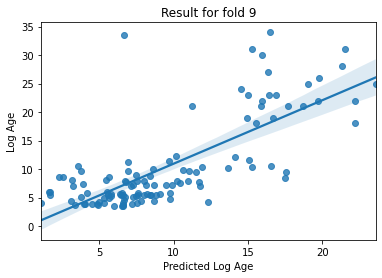

In [114]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_MSDL_motion = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_MSDL_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [2]:
from datalad import api

api.save(path='../Analysis_Data', message='Add all .csv files generated for confound analysis to Analysis_Data')


[WARNING] realpath of PWD=/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project is /Users/Storme/brainhack/Project/stephaniealley_bhs2020_project whenever os.getcwd()=/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Command_Files. From now on will be returning os.getcwd(). Directory symlinks in the paths will be resolved 


[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data/aal_CSF_0.csv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data/aal_CSF_1.csv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data/aal_CSF_10.csv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data/aal_CSF_100.csv',
  'type': 'file',
  'refd

# Test model on unseen data

In [124]:
def train_val_final(X_features, y_age, age_class):
    X_train, X_val, y_train, y_val = train_test_split(
                                                        X_features, # x
                                                        y_age, # y
                                                        test_size = 0.25, # 60%/40% split  
                                                        shuffle = True, # shuffle dataset
                                                                        # before splitting
                                                        stratify = age_class,  # keep
                                                                               # distribution
                                                                               # of ageclass
                                                                               # consistent
                                                                               # betw. train
                                                                               # & test sets.
                                                        random_state = 123 # same shuffle each
                                                                           # time
                                                                           )
    return X_train, X_val, y_train, y_val

In [126]:
def model_fit_final(X_train, X_val, y_train):
    # Build a tiny pipeline that does feature selection (top 20% of features), 
    # and then prediction with our linear svr model.
    model = Pipeline([
        ('feature_selection',SelectPercentile(f_regression,percentile=20)),
        ('prediction', l_svr)
                     ])
    
    # Run pipeline 
    model.fit(X_train, y_train) # Fit data to the model using mini pipeline
    y_pred = model.predict(X_val)
        
    return y_pred

### Create empty dictionary for output

In [122]:
output = { 'BASC': 
           { 'All': { 'y_pred': {}, 'y_val': {}},  
           'CSF': { 'y_pred': {}, 'y_val': {}},
           'WM': { 'y_pred': {}, 'y_val': {}},
           'Global': { 'y_pred': {}, 'y_val': {}},
           'Motion': { 'y_pred': {}, 'y_val': {}}},  
          'AAL': 
          { 'All': { 'y_pred': {}, 'y_val': {}},  
            'CSF': { 'y_pred': {}, 'y_val': {}},
            'WM': { 'y_pred': {}, 'y_val': {}},
            'Global': { 'y_pred': {}, 'y_val': {}},
            'Motion': { 'y_pred': {}, 'y_val': {}}},
          'CRAD': 
          { 'All': { 'y_pred': {}, 'y_val': {}},  
            'CSF': { 'y_pred': {}, 'y_val': {}},
            'WM': { 'y_pred': {}, 'y_val': {}},
            'Global': { 'y_pred': {}, 'y_val': {}},
            'Motion': { 'y_pred': {}, 'y_val': {}}},
         'MSDL': 
          { 'All': { 'y_pred': {}, 'y_val': {}},  
            'CSF': { 'y_pred': {}, 'y_val': {}},
            'WM': { 'y_pred': {}, 'y_val': {}},
            'Global': { 'y_pred': {}, 'y_val': {}},
            'Motion': { 'y_pred': {}, 'y_val': {}}}}

## Functional atlas

### Perform SVR Analysis-all confounds

In [139]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_basc)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_BASC_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['BASC']['All']['y_pred'] = y_pred
output['BASC']['All']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

R2: 0.6570126572210194
MAE: 3.2527349644173627


### Perform SVR Analysis-CSF

In [142]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_basc)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_BASC_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['BASC']['CSF']['y_pred'] = y_pred
output['BASC']['CSF']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

R2: 0.6377198352615738
MAE: 3.102617629558893


### Perform SVR Analysis-WM

In [143]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_basc)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_BASC_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['BASC']['WM']['y_pred'] = y_pred
output['BASC']['WM']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

R2: 0.5852986697601493
MAE: 3.2903103620146883


### Perform SVR Analysis-global

In [144]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_basc)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_BASC_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['BASC']['Global']['y_pred'] = y_pred
output['BASC']['Global']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

R2: 0.6618481612138503
MAE: 3.1661906700481337


### Perform SVR Analysis-motion

In [145]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_basc)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_BASC_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['BASC']['Motion']['y_pred'] = y_pred
output['BASC']['Motion']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

R2: 0.653689531328016
MAE: 3.1865708687985794


## Structural atlas

### Perform SVR Analysis-all confounds

In [146]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_aal)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_AAL_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['AAL']['All']['y_pred'] = y_pred
output['AAL']['All']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

R2: 0.6420712474098078
MAE: 3.367534988400175


### Perform SVR Analysis-CSF

In [147]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_aal)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_AAL_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['AAL']['CSF']['y_pred'] = y_pred
output['AAL']['CSF']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

R2: 0.560149039595679
MAE: 3.5801184904902876


### Perform SVR Analysis-WM

In [150]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_aal)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_AAL_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['AAL']['WM']['y_pred'] = y_pred
output['AAL']['WM']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

R2: 0.5672332108678864
MAE: 3.4248805390972166


### Perform SVR Analysis-global

In [151]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_aal)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_AAL_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['AAL']['Global']['y_pred'] = y_pred
output['AAL']['Global']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

R2: 0.6630173158539212
MAE: 3.16305352415207


### Perform SVR Analysis-motion

In [152]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_aal)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_AAL_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['AAL']['Motion']['y_pred'] = y_pred
output['AAL']['Motion']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

R2: 0.6561182544250594
MAE: 3.3606486218421505


## Clustering method atlas

### Perform SVR Analysis-all confounds

In [153]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_crad)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_CRAD_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['CRAD']['All']['y_pred'] = y_pred
output['CRAD']['All']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


R2: 0.4587900015903834
MAE: 4.0795438119714635


### Perform SVR Analysis-CSF

In [154]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_crad)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_CRAD_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['CRAD']['CSF']['y_pred'] = y_pred
output['CRAD']['CSF']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


R2: 0.4758465741938186
MAE: 3.9677537018327516


### Perform SVR Analysis-WM

In [155]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_crad)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_CRAD_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['CRAD']['WM']['y_pred'] = y_pred
output['CRAD']['WM']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


R2: 0.46195178590331976
MAE: 4.187143557855057


### Perform SVR Analysis-global

In [156]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_crad)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_CRAD_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['CRAD']['Global']['y_pred'] = y_pred
output['CRAD']['Global']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


R2: 0.4290910037119554
MAE: 4.231465483250945


### Perform SVR Analysis-motion

In [157]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_crad)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_CRAD_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['CRAD']['Motion']['y_pred'] = y_pred
output['CRAD']['Motion']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


R2: 0.42647591354746583
MAE: 4.265788117617321


## Linear decomposition method atlas

### Perform SVR Analysis-all confounds

In [158]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_msdl)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_MSDL_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['MSDL']['All']['y_pred'] = y_pred
output['MSDL']['All']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


R2: 0.4001689268110099
MAE: 3.7813961509975083


### Perform SVR Analysis-CSF

In [159]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_msdl)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_MSDL_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['MSDL']['CSF']['y_pred'] = y_pred
output['MSDL']['CSF']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


R2: 0.3666956282064642
MAE: 4.102518229639522


### Perform SVR Analysis-WM

In [160]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_msdl)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_MSDL_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['MSDL']['WM']['y_pred'] = y_pred
output['MSDL']['WM']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


R2: 0.374085401952453
MAE: 3.8675025128882807


### Perform SVR Analysis-global

In [161]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_msdl)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_MSDL_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['MSDL']['Global']['y_pred'] = y_pred
output['MSDL']['Global']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


R2: 0.41148672352003424
MAE: 3.7729855262969068


### Perform SVR Analysis-motion

In [162]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_msdl)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_MSDL_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['MSDL']['Motion']['y_pred'] = y_pred
output['MSDL']['Motion']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


R2: 0.4197878947880206
MAE: 3.6188751080924693


In [166]:
# Save results for interactive figure
sio.savemat('../Analysis_Data/output.mat', output);

[23.          9.94       23.          8.66        5.99       33.44
 10.38        5.55        4.47364819  7.43        5.81        8.15
  5.12        9.59        8.59        3.86584531 33.          8.76
  5.46        7.91       30.          5.99        9.48        4.36413416
  3.93155373 21.         21.          7.71        5.46        3.93155373
  3.51813826  5.56       22.          7.13        4.83778234 10.78
  7.13        7.66        5.54      ]
